In [1]:
import pyzed.sl as sl
import numpy as np
from tqdm import tqdm
import copy

import matplotlib.pyplot as plt
import mediapy as media
import cv2

import h5py

In [2]:
# Create the camera
zed = sl.Camera()

init_params = sl.InitParameters()
init_params.camera_resolution = sl.RESOLUTION.AUTO
init_params.camera_fps = 30
init_params.coordinate_system = sl.COORDINATE_SYSTEM.RIGHT_HANDED_Y_UP
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_mode = sl.DEPTH_MODE.PERFORMANCE

# Open the camera
err = zed.open(init_params)
if err != sl.ERROR_CODE.SUCCESS:
    print("Camera Open : "+repr(err)+". Exit program.")
    exit()

[2024-05-13 12:48:43 UTC][ZED][INFO] Logging level INFO
[2024-05-13 12:48:44 UTC][ZED][INFO] Using USB input... Switched to default resolution HD720
[2024-05-13 12:48:44 UTC][ZED][INFO] [Init]  Depth mode: PERFORMANCE
[2024-05-13 12:48:45 UTC][ZED][INFO] [Init]  Camera successfully opened.
[2024-05-13 12:48:45 UTC][ZED][INFO] [Init]  Camera FW version: 1523
[2024-05-13 12:48:45 UTC][ZED][INFO] [Init]  Video mode: HD720@30
[2024-05-13 12:48:45 UTC][ZED][INFO] [Init]  Serial Number: S/N 37004490


In [3]:
# Enable positional tracking with default parameters
py_transform = sl.Transform()  # First create a Transform object for TrackingParameters object
tracking_parameters = sl.PositionalTrackingParameters(_init_pos=py_transform)
err = zed.enable_positional_tracking(tracking_parameters)
if err != sl.ERROR_CODE.SUCCESS:
    print("Enable positional tracking : "+repr(err)+". Exit program.")
    zed.close()
    exit()

In [4]:
image = sl.Mat()
pose = sl.Pose()
images = []
image_timesteps = []
poses = []
pose_timesteps = []
runtime_parameters = sl.RuntimeParameters()

frames = 300

for _ in tqdm(range(frames)):
    if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    
        # Get an image
        zed.retrieve_image(image, sl.VIEW.LEFT)
        image_timesteps.append(image.timestamp.get_milliseconds())
    
        images.append(image.get_data(deep_copy=True))
    
        # Get the pose
        tracking_state = zed.get_position(pose, sl.REFERENCE_FRAME.WORLD)
        
        if tracking_state == sl.POSITIONAL_TRACKING_STATE.OK:    
            py_translation = sl.Translation()
            py_orientation = sl.Orientation()
            pose_timesteps.append(pose.timestamp.get_milliseconds())
    
            poses.append(np.concatenate((
                pose.get_translation(py_translation).get(),
                pose.get_orientation(py_orientation).get()
            )))

100%|██████████| 300/300 [00:09<00:00, 30.03it/s]


In [5]:
# Close the camera
zed.close()

In [6]:
rgb_images = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in images]
poses = np.array(poses)

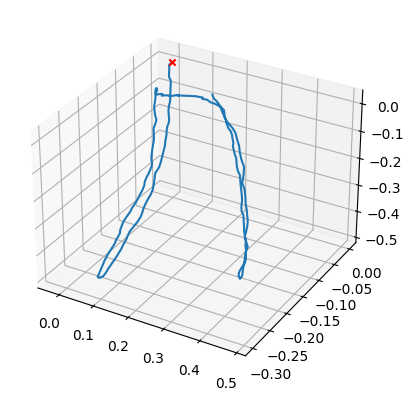

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot(poses[:,0], poses[:,1], poses[:,2])
ax.scatter(*poses[0,:3], color = 'red', marker = 'x')
plt.show()


In [8]:
media.show_video(rgb_images, fps=init_params.camera_fps)

In [9]:
path = 'recording.hdf5'
f = h5py.File(path, 'w')
    
f.create_dataset('image_timesteps', data=np.array(image_timesteps))
f.create_dataset('images', data=np.array(images))
f.create_dataset('pose_timesteps', data=np.array(pose_timesteps))
f.create_dataset('poses', data=np.array(poses))
    
f.close()
print(f'Saved data to {path}')

Saved data to recording.hdf5
